In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
#from azure.ai.vision.imageanalysis.models import VisualFeatures

from msrest.authentication import CognitiveServicesCredentials
from array import array
import os
from PIL import Image
import sys
import time
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

In [2]:
subscription_key = os.environ["VISION_KEY"]
endpoint = os.environ["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

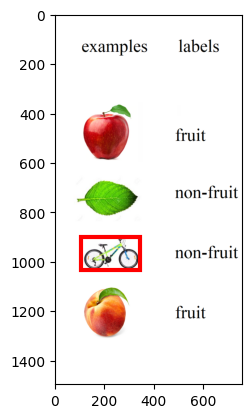

In [3]:
predicted_bike_bb = []
cutii = []
fisiere_cu_bicle = []
fisiere_fara_bicle = []

for filename in os.scandir("images"):
    if filename.is_file():
        nume_fisier = filename.path
        switch=False
        img = open(nume_fisier,"rb")
        result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])

        for ob in result.objects:
            if(ob.object_property == "bicycle") or (ob.object_property == "bike"):
                switch=True
                predicted_bike_bb.clear()
                predicted_bike_bb = [ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h]
                cutii.append([filename.name,ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h])

                plt.cla()
                im = plt.imread(nume_fisier)
                plt.imshow(im)
                ax = plt.gca()
                ax.add_patch(plt.Rectangle(xy = (predicted_bike_bb[0], predicted_bike_bb[1]), width = predicted_bike_bb[2]-predicted_bike_bb[0], height = predicted_bike_bb[3]-predicted_bike_bb[1], fill = False, color = "red", linewidth = 3))
                plt.savefig("images_ai/"+filename.name)

        if switch:
            fisiere_cu_bicle.append(filename.name)
        else:
            fisiere_fara_bicle.append(filename.name)

In [4]:
fisiere_actuale_cu_bicle = ['bike02.jpg', 'bike03.jpg', 'bike04.jpg', 'bike05.jpg', 'bike06.jpg', 'bike07.jpg', 'bike08.jpg', 'bike09.jpg', 'bike1.jpg', 'bike10.jpg','binClass.png','traffic05.jpg','traffic06.jpg','traffic08.jpg']
fisiere_actuale_fara_bicle = ['animals.png', 'cm.png', 'IoU.png', 'IoU2.png', 'objectDetection.png', 'people.jpg', 'PR.png', 'traffic01.jpg', 'traffic02.jpg', 'traffic03.jpg', 'traffic04.jpg','traffic07.jpg', 'traffic09.jpg', 'traffic10.jpg']
cutii_actuale = [
    ['bike1.jpg',1,26,415,415],
    ['bike02.jpg',17,87,380,326],
    ['bike03.jpg',152,145,350,407],
    ['bike04.jpg',1,1,415,415],
    ['bike05.jpg',64,59,359,348],
    ['bike06.jpg',152,145,350,407],
    ['bike07.jpg',58,200,299,415],
    ['bike08.jpg',50,42,391,351],
    ['bike09.jpg',1,18,378,389],
    ['bike10.jpg',138,120,377,410],
    ['binClass.png',123,895,341,1031],
    ['traffic05.jpg',557,332,596,379],
    ['traffic06.jpg',233,321,271,355],
    ['traffic08.jpg',311,321,329,372]
]

In [5]:
def iou(box1,box2): #Intersection over Union
    interX1=max(box1[0],box2[0])
    interY1=max(box1[1],box2[1])
    interX2=min(box1[2],box2[2])
    interY2=min(box1[3],box2[3])

    width_inner = abs(interX2-interX1)
    height_inner = abs(interY2-interY1)

    Arie_1si2 = width_inner * height_inner
    
    Arie_1 = (abs(box1[2]-box1[0]))*(abs(box1[3]-box1[1]))
    Arie_2 = (abs(box2[2]-box2[0]))*(abs(box2[3]-box2[1]))
    
    Arie_1sau2 = (Arie_1 + Arie_2) - Arie_1si2

    return Arie_1si2/Arie_1sau2

for cutie in cutii_actuale:
    switch = True
    for i in range(len(cutii)):
        if(cutie[0]==cutii[i][0]):
            print(cutie[0],"   ",iou(cutie[1:5],cutii[i][1:5]))
            switch = False
    if switch:
        print(cutie[0],"   ",0)



bike1.jpg     0.9510706326906307
bike02.jpg     0.9098696461824953
bike03.jpg     0.8889659958362248
bike04.jpg     0.9855883962143348
bike05.jpg     0.8511834706420819
bike06.jpg     0
bike07.jpg     0.9089252201530243
bike08.jpg     0
bike09.jpg     0.9319056027815422
bike10.jpg     0.8797826919918988
binClass.png     0.8755286457540998
traffic05.jpg     0
traffic06.jpg     0
traffic08.jpg     0


In [6]:
TP = len(list(set(fisiere_actuale_cu_bicle).intersection(fisiere_cu_bicle)))
TN = len(list(set(fisiere_actuale_fara_bicle).intersection(fisiere_fara_bicle)))
FP = len(list(set(fisiere_actuale_fara_bicle).intersection(fisiere_cu_bicle)))
FN = len(list(set(fisiere_actuale_cu_bicle).intersection(fisiere_fara_bicle)))

acc = (TP+TN)/(TP+TN+FP+FN) # performanta overall
precision = TP/(TP+FP) # accuratetea predictiilor pozitive
recall = TP/(TP+FN) # coverage-ul la pozitive

print(acc)
print(precision)
print(recall)

0.8214285714285714
1.0
0.6428571428571429


In [7]:
for cutie in cutii_actuale:
    err = 0
    for cutie2 in cutii:
        if(cutie[0]==cutie2[0]):
            for v in zip(cutie[1:], cutie2[1:]):
                err = err + (v[0] - v[1])**2
                err /= 4
    print(f"detection error for {cutie[0]}: ", err)


detection error for bike1.jpg:  8.390625
detection error for bike02.jpg:  18.890625
detection error for bike03.jpg:  11.03515625
detection error for bike04.jpg:  2.33203125
detection error for bike05.jpg:  56.78125
detection error for bike06.jpg:  0
detection error for bike07.jpg:  6.06640625
detection error for bike08.jpg:  0
detection error for bike09.jpg:  45.59765625
detection error for bike10.jpg:  24.765625
detection error for binClass.png:  4.0625
detection error for traffic05.jpg:  0
detection error for traffic06.jpg:  0
detection error for traffic08.jpg:  0
